
 **Bismillah Al-Rahman Al-Raheem**

In this Notebook I will be using some recent skills I've learned from a Deep Learning Specialization course I completed. I will be using a CNN and RNN (LSTM) to make predictions.

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

**Import Packages**

Pickle - joblib

In [1]:
import sys

# ------------------------------------------------------------------------------
# constants

MODULE_PATH = '../project'

# ------------------------------------------------------------------------------
# load packages

sys.path.append(MODULE_PATH)
from utils.kt_utils import *
from utils.cnn_utils import *

#Custom Packages from Deep Learning Specialization Course - Coursera
# import module we'll need to import our custom module
from shutil import copyfile
# copy our file into the working directory (make sure it has .py suffix)
#copyfile(src = "../utils/kt_utils.py", dst = "../working/kt_utils.py")
#copyfile(src = "../utils/cnn_utils.py", dst = "../working/cnn_utils.py")
# import all our functions

from utils.kt_utils import *
#from res_net_50 import *
import joblib
import os
import pandas as pd
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import cv2
import gc

%matplotlib inline

Using TensorFlow backend.


**Exploratory Data Analysis**

In [2]:
#Let's see how many train images we have in our training set
train_csv = pd.read_csv('../data/train.csv')
test_csv = pd.read_csv('../data/sample_submission.csv')
print("Preview of our Dataset\n", train_csv.head())
print("Training set size:", train_csv.shape)


Preview of our Dataset
           Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3
Training set size: (9850, 2)


As we can see, our datset csv has an "Image" Column where the image is, and an "Id" column to identify the corresponding whale image class. 
We have 9850 images to work with. We will later decide if we should use the entire dataset to train or select a sample size.


In [3]:
print("There are", train_csv.Id.nunique(), "classes")

There are 4251 classes



Our Training set has 4251 different Classes. These classes, after being encoded,  will be our Target Variable.

**Let's check the Class distribution of our training set.**

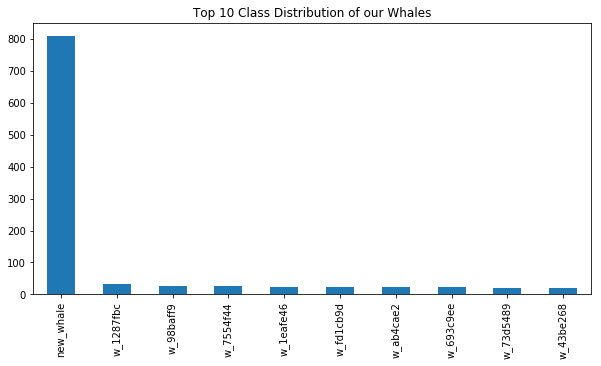

In [4]:
train_csv.Id.value_counts().head(10).plot.bar(title='Top 10 Class Distribution of our Whales'
                                             , figsize= (10,5))

There's some major class imbalance, as we can see "new_whale" far outnumbers there rest of the IDs.
Let's first remove the new_whale class that is causing the major imbalance, and then see the distribution of the rest of our classes

In [5]:
images_remove = train_csv[train_csv['Id'] == 'new_whale']['Image'].reset_index(drop=True)


In [6]:
train_csv = train_csv[train_csv['Id'] != 'new_whale']
train_csv.Id.value_counts().head()


w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_fd1cb9d    22
Name: Id, dtype: int64

In [7]:
train_csv.reset_index(drop=True, inplace=True)

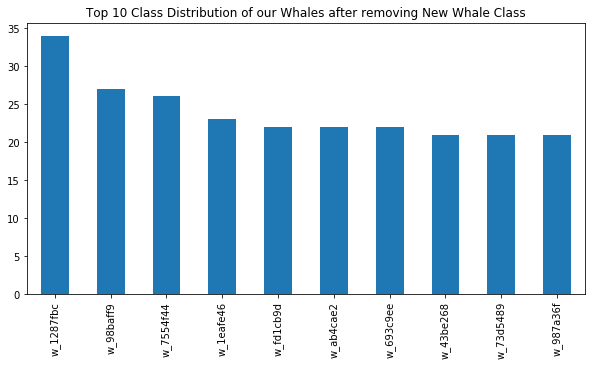

In [8]:
train_csv.Id.value_counts().head(10).plot.bar(title='Top 10 Class Distribution of our Whales after removing New Whale Class'
                                             , figsize= (10,5))

In [9]:
print("There are now", train_csv.Id.nunique(), "classes")

There are now 4250 classes


**Let's have a look at our datset**

In [10]:
#train_dir = "../input/humpback-whale-identification/train" #train.zip file directory
test_dir = "../data/test/test" #test.zip file directory
#train_list = ["../input/humpback-whale-identification/train/{}".format(i) for i in os.listdir(train_dir)] #Retrieve all train images
test_list = ["../data/test/test/{}".format(i) for i in os.listdir(test_dir)] #Retrieve all test images

#del train_dir #clear lists that are no longer of use
#del test_dir
#gc.collect() #collect garbage to save memory

In [11]:
#random.shuffle(train_csv) #Shuffle the dataset randomly
# So that the dev and test set have the same distribution
train_csv = train_csv.sample(frac=1)


In [12]:
train_list =[]
for i in range(len(train_csv)):
    train_list.append("../data/train/train/" + train_csv['Image'][i])
    
    

In [13]:
len(train_list)

9040

Let's have a look at some of our Whale Pictures!

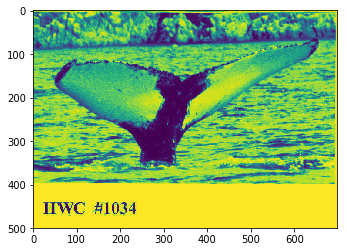

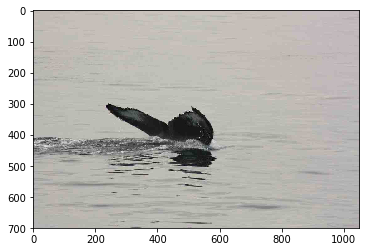

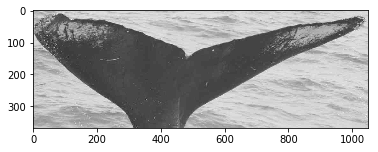

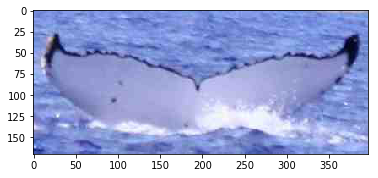

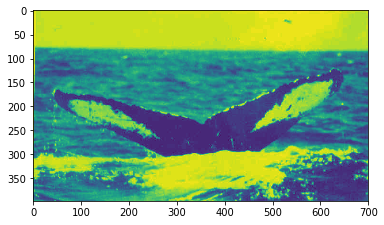

In [14]:
for img in train_list[:5]:
    img = mpimg.imread(img)
    image_plot = plt.imshow(img)
    plt.show()


**Data Pre-processing**

Let's create some custom function to pre-process our images.
We will use OpenCV to read and resize our images.

We will be using the following dimensions for our images  (m, 224, 224, 3). 

In [15]:
def preprocess_whale(image_paths):
    """A function to preprocess image dataset.
    By resizing the images and turning them into arrays
    
    Parameters:
    m: int
        The training set size
    image_paths: string
        A string with the image paths of the dataset
        
    Returns:
    A 2D Numpy array
    """
    #X = np.zeros((m,100,100,3))
    #index = 0
    #for path in image_paths:
        #img = image.load_img(path, target_size=(100,100,3))
        #x = image.img_to_array(img)
        #x = preprocess_input(x)
    
    X= []
    for image in image_paths:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR) # not black and white,
                                      (224,224), interpolation= cv2.INTER_CUBIC)) #use 224, 224, 3 Dimensions 
    
    
    #Initialize inpiut with zeros of desires dimensions
    #X[index] = x
    #index =+ 1
           
    return X


In [16]:
def encode_labels(df, y_col ):
    Label_enc = LabelEncoder()
    y = df[y_col]
    int_encoded = Label_enc.fit_transform(y)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    y = y.values.reshape(len(y), 1) # matrix dimensions shape
    onehot_y = onehot_encoder.fit_transform(y)
    # Sanity check
    df['encoded'] = int_encoded
    df
    return df, onehot_y

In [17]:
df_encoded ,Y_train = encode_labels(train_csv, y_col = 'Id')

In [ ]:
joblib.dump(df_encoded, "../data/df_encoded.pkl")
joblib.dump(Y_train, '../data/Y_train.pkl')

In [19]:
#gc.collect()

The column value of the Shape of our Y_train array should be 4250 as there are that many classes, Let's check

In [20]:
Y_train.shape

(9040, 4250)

In [21]:
X_train = preprocess_whale(train_list )

In [22]:
joblib.dump(X_train, '../data/X_train.pkl')

['../data/X_train.pkl']

In [23]:
import pickle
# Save the best result
#be_result=be.predict(test_filtered_scaled)
# Save the model
pickle.dump(X_train, open('../data/X_train.pkl', 'wb'))



In [24]:
# some time later...
 
# load the model from disk
result = pickle.load(open('../data/X_train.pkl', 'rb'))
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
#X_submit = preprocess_whale(test_list)
#joblib.dump(X_submit, '../input/X_submit.pkl')

In [26]:
#gc.collect()

In [27]:
#Normalize the inputs in order to let our cost function optimize faster and to scale our Data
X_train = np.array(X_train)/ 255
#X_submit = np.array(X_submit) / 255

In [ ]:
# convert list into an array for training
# memory error
X_train = np.array(X_train)

In [30]:
print(X_train.shape)
print(Y_train.shape)

#print(X_submit.shape)

(9040, 224, 224, 3)
(9040, 4250)


Split our Data into a Train, Dev and Test
We will train on our Train Data, evaluate and tune the model using our Dev Data and then finally Test on our Hold-out Data (Test Data)

Include a random shuffle before splitting the data (done earlier)

In [31]:
X_train_set = X_train[:8840]
Y_train_set = Y_train[:8840]
X_dev_set = X_train[8840:8940]
Y_dev_set = Y_train[8840:8940]
X_holdout_set = X_train[8940:]
Y_holdout_set = Y_train[8940:]



To get started with our ConvNet, it's useful to look at the shapes of our dataset


In [32]:
print ("number of training examples = " + str(X_train_set.shape[0]))
print ("number of dev set examples = " + str(X_dev_set.shape[0]))
print ("X_train shape: " + str(X_train_set.shape))
print ("Y_train shape: " + str(Y_train_set.shape))
print ("X_dev shape: " + str(X_dev_set.shape))
print ("Y_dev shape: " + str(Y_dev_set.shape))
print ( "X_holdout_set" + str(X_holdout_set.shape))
print ("Y_holdout_set" + str(Y_holdout_set.shape))

number of training examples = 8840
number of dev set examples = 100
X_train shape: (8840, 224, 224, 3)
Y_train shape: (8840, 4250)
X_dev shape: (100, 224, 224, 3)
Y_dev shape: (100, 4250)
X_holdout_set(100, 224, 224, 3)
Y_holdout_set(100, 4250)


[](http://)Let's build our ConvNet! I will be using Keras for this model. (Tensorflow perhaps later to upskill)

In [33]:
def model_convnet(layers= 10 , dropout=0.8, activation=None, optimizor= 'Adam'):
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (224, 224, 3)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(Flatten())
    model.add(Dense(layers, activation="relu", name='rl'))
    model.add(Dropout(dropout))
    model.add(Dense(Y_train_set.shape[1], activation='softmax', name='sm'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizor, metrics=['accuracy'])
    print(model.summary())
    
    return model

In [34]:
trainer = model_convnet().fit(X_train_set, Y_train_set, epochs = 100, batch_size = 32, 
          validation_data=(X_dev_set, Y_dev_set), verbose=0)


W0725 23:44:45.172843 139796456670976 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 23:44:45.566192 139796456670976 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 23:44:45.799499 139796456670976 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 23:44:46.053709 139796456670976 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 218, 218, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 109, 109, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 107, 107, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 107, 107, 64)      0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 35, 35, 64)        0         
__________

KeyboardInterrupt: 

In [ ]:
joblib.dump(trainer, '../data/conv_net_model.pkl')

In [ ]:
#gc.collect()

In [ ]:
# summarize history for accuracy
plt.plot(trainer.history['acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Change model distribution. For Dev and Test. Radomize train , put X and y in one Dataframe and shuffle, then train

Grid Search to help tune hyperparameters and fix overfitting. (Takes extremely long, haven't done yet)

In [ ]:
# create model
model = KerasClassifier(build_fn= model_convnet, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=5,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train_set, Y_train_set)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
joblib.dump(grid_results, "../input/Grid_search.pkl")

In [ ]:
gc.collect()

Our Grid Search is proving to be computationally expensive, a random search could be tried but to try bypass the overfitting, a new model arcgitecture will have to be chosen

In comes VGG-16 pretrained model

In [42]:
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(model.summary())

58892288/58889256 [==============================] - 51s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_poo

In [43]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f241ff77160> False
<keras.layers.convolutional.Conv2D object at 0x7f241ff77908> False
<keras.layers.convolutional.Conv2D object at 0x7f241ff77dd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f241ffb6dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f241ffb6438> False
<keras.layers.convolutional.Conv2D object at 0x7f241fec6940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f241fedae10> False
<keras.layers.convolutional.Conv2D object at 0x7f241feda3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f241fe864a8> False
<keras.layers.convolutional.Conv2D object at 0x7f241fe9cc18> False
<keras.layers.pooling.MaxPooling2D object at 0x7f241feaf7f0> False
<keras.layers.convolutional.Conv2D object at 0x7f241feaf4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f241fe5fac8> False
<keras.layers.convolutional.Conv2D object at 0x7f241fe76f98> False
<keras.layers.pooling.MaxPooling2D object at 0x7f241fe05a58>

In [46]:
def vgg_unfreeze(vgg_conv=vgg_conv):
    # Create the model
    model = models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4250, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model


unfreeze dense layers to get right amount of predictions

In [40]:
vgg = vgg_unfreeze().fit(X_train_set, Y_train_set, epochs = 100, batch_size = 32, 
          validation_data=(X_dev_set, Y_dev_set), verbose=0)

ValueError: Error when checking target: expected predictions to have shape (1000,) but got array with shape (4250,)

In [ ]:
# summarize history for accuracy
plt.plot(vgg.history['acc'])
plt.plot(vgg.history['val_acc'])
plt.title('model accuracy VGG-16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()